# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Импорт библиотек и изучение DF

In [1]:
#импортируем библиотеки
import pandas as pd
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
#читаем файл
df=pd.read_csv('/datasets/users_behavior.csv')

In [3]:
#посмотрим несколько рандомных строк в дф
df.sample(10)

,calls,minutes,messages,mb_used,is_ultra
29,50.0,358.01,44.0,9998.83,1
2869,72.0,415.78,26.0,12494.21,0
2399,75.0,543.44,42.0,14193.04,0
1086,70.0,420.32,0.0,15814.41,0
1972,5.0,13.39,0.0,2292.07,0
609,51.0,368.20,30.0,20699.67,0
2440,62.0,466.60,0.0,17353.48,0
2692,97.0,742.03,81.0,14996.51,0
766,51.0,298.15,6.0,9220.92,0
53,67.0,421.27,33.0,14865.74,1


**Описание данных**

- **сalls** — количество звонков.

- **minutes** — суммарная длительность звонков в минутах.

- **messages** — количество sms-сообщений.

- **mb_used** — израсходованный интернет-трафик в Мб.

- **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


In [4]:
#посмотрим общую информацию о таблице,количество дубликатов и кол-во строк
df.info()
print('Дублитов:',df.duplicated().sum())
print('Количество строк:',df.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
Дублитов: 0
Количество строк: 3214


Заменим **float64** ==> **float32**, это срежет затраты на память

In [5]:
df['calls']=df['calls'].astype('float32')
df['minutes']=df['minutes'].astype('float32')
df['messages']=df['messages'].astype('float32')
df['mb_used']=df['mb_used'].astype('float32')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float32
 1   minutes   3214 non-null   float32
 2   messages  3214 non-null   float32
 3   mb_used   3214 non-null   float32
 4   is_ultra  3214 non-null   int64  
dtypes: float32(4), int64(1)
memory usage: 75.5 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038891,33.236366,0.0,40.000000,62.000000,82.000000,244.000000
minutes,3214.0,438.208771,234.569870,0.0,274.574997,430.600006,571.927521,1632.060059
messages,3214.0,38.281269,36.148327,0.0,9.000000,30.000000,57.000000,224.000000
mb_used,3214.0,17207.673828,7570.968262,0.0,12491.902588,16943.234375,21424.699707,49745.730469
is_ultra,3214.0,0.306472,0.461100,0.0,0.000000,0.000000,1.000000,1.000000


In [8]:
df.isna().sum()
pd.DataFrame(df.isna().mean()*100).style.set_precision(1).background_gradient('coolwarm')

,0
calls,0.0
minutes,0.0
messages,0.0
mb_used,0.0
is_ultra,0.0


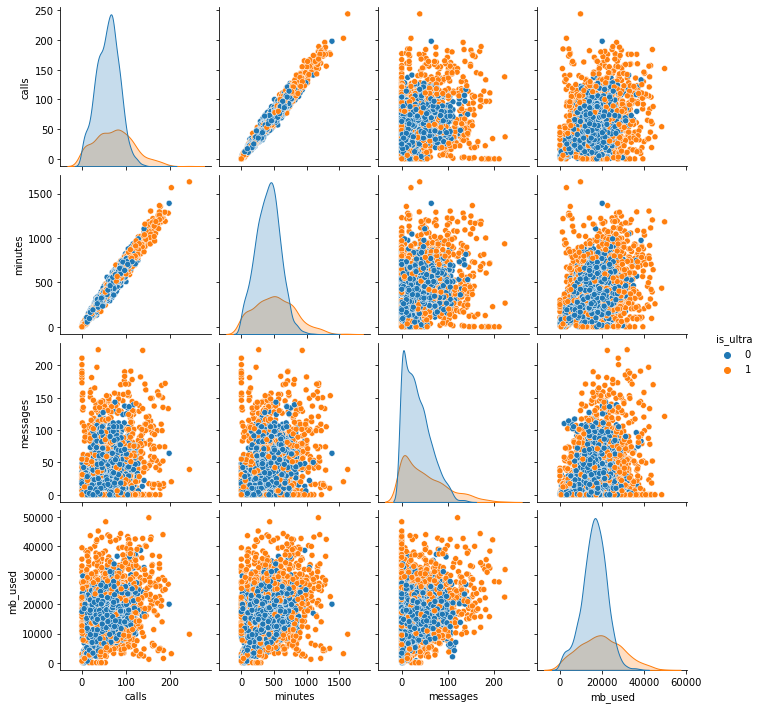

In [9]:
sns.pairplot(df,hue='is_ultra');

### Вывод

- При изучении ДФ,была импортирована и использована библиотека pandas

- Просмотрены 10 рандомных строк

- Состалено описание столбцов

- ДФ состоит из 5 колонок(4 из которых являются типом float 32 ) и 1 колонкой (int64)

- Дубликаты и пропуски отсутвуют

- Наблюдается сильная кореляция между звонками и минуматами

## Разбейте данные на выборки

Разобъём данные на 3 выборки

- **Тренировочная -** 60%

**Валидационная -** 20%

**Тестовая -** 20%

In [10]:
features=df.drop('is_ultra',axis=1)
target=df['is_ultra']
#отделим 40% на валидационную и тестовую выборку

features_train,features_v_t,target_train,target_v_t=train_test_split(
                            features,target,test_size=0.4,random_state=12345)
#разобъем их пополам,что бы в каждой было по 20 %

features_test,features_valid,target_test,target_valid=train_test_split(
                            features_v_t,target_v_t,test_size=0.5,random_state=12345)

In [11]:
print('Тренировочная:',target_train.shape[0])
print('Валидационная:',target_valid.shape[0])
print('Тестовая:',target_test.shape[0])

Тренировочная: 1928
Валидационная: 643
Тестовая: 643


### Вывод

Данные успешно разбиты на воыборки

## Исследуйте модели

Для иследование протестуируем 3 модели

- **Лес деревьев**  -------  **DecisionTreeClassifier**
- **Логистическая регресия** -------  **LogisticRegression**
- **Случайный лес** ------- **RandomForest**

### DecisionTreeClassifier

In [12]:
best_result = 0
best_depth = 0
history=[]
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12, max_depth=depth)# инициализируйте модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model.fit(features_train,target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
    result = accuracy_score(target_valid, predictions_valid)  # посчитайте значение метрики rmse на валидационной выборке
    history.append(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print("accuracy наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

accuracy наилучшей модели на валидационной выборке: 0.7993779160186625 Глубина дерева: 7


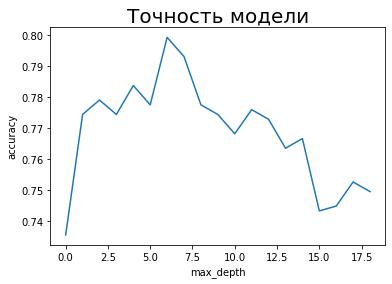

In [13]:
plt.plot(history)
plt.title('Точность модели', fontsize=20)
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show;

### LogisticRegression

In [14]:
# Логистическая регрессия
lr_model = LogisticRegression(random_state=123, solver='lbfgs', max_iter=1000) 
lr_model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
predictions_valid = lr_model.predict(features_valid) # получаем предсказания модели на валидационной выборке
result = accuracy_score(target_valid, predictions_valid) # значение метрики accuracy на валидационной выборке
best_model = lr_model
best_result = result
      
print("accuracy модели на валидационной выборке:", best_result)

accuracy модели на валидационной выборке: 0.6842923794712286


### RandomForest

In [15]:
best_result = 0
history_rf = []
for est in range(10, 101, 10):
    for depth in range(1,15):
        model = RandomForestClassifier(random_state=1234, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
        result = accuracy_score(target_valid, predictions_valid) # значение метрики accuracy на валидационной выборке
        history_rf.append(result)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

print("accuracy наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth, 'Количество деревьев:', best_est)

accuracy наилучшей модели на валидационной выборке: 0.8133748055987559 Глубина дерева: 11 Количество деревьев: 20


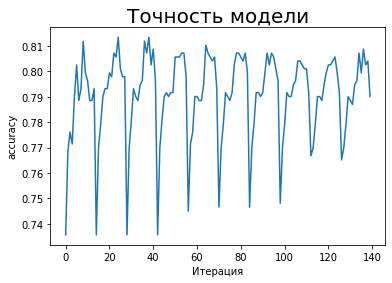

In [16]:
plt.plot(history_rf);
plt.title('Точность модели', fontsize=20)
plt.ylabel('accuracy')
plt.xlabel('Итерация')
plt.show;

In [17]:
# Случайный лес с автоподбором параметров
parametrs = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1,15)}

model = RandomForestClassifier(random_state=1234)
grid_model = GridSearchCV(model, parametrs)


grid_model.fit(features_train, target_train) # обучаем модель на тренировочной выборке

predictions_valid = grid_model.predict(features_valid) # получаем предсказания модели на валидационной выборке
result = accuracy_score(target_valid, predictions_valid) # значение метрики accuracy на валидационной выборке


print('Параметры модели:', grid_model.best_params_)
print("accuracy наилучшей модели на валидационной выборке:", result)

Параметры модели: {'max_depth': 12, 'n_estimators': 50}
accuracy наилучшей модели на валидационной выборке: 0.8040435458786936


In [18]:
# Случайный лес с автоподбором параметров
param_dist  = {'n_estimators': sp_randint (10, 101, 10),
               'max_depth': sp_randint(1, 15)
              }

model = RandomForestClassifier(random_state=1234)
rc_model = RandomizedSearchCV(model, param_dist)

rc_model.fit(features_train, target_train) # обучаем модель на тренировочной выборке

predictions_valid = rc_model.predict(features_valid) # получаем предсказания модели на валидационной выборке
result = accuracy_score(target_valid, predictions_valid) # значение метрики accuracy на валидационной выборке

print('Параметры модели:', rc_model.best_params_)
print("accuracy наилучшей модели на валидационной выборке:", result)

Параметры модели: {'max_depth': 9, 'n_estimators': 56}
accuracy наилучшей модели на валидационной выборке: 0.80248833592535


Максимальное accuracy моделей RandomForestClassifier составило 0.81

### Вывод

**Лучшая модель**

- RandomForestClassifier
- Глубина дерева:11
- Количество деревьев: 20

## Проверьте модель на тестовой выборке

In [19]:
features_train = features_train.append(features_valid)
target_train = target_train.append(target_valid)
best_model.fit(features_train, target_train)
print('Тренировочная выборка:', features_train.shape, target_train.shape)

Тренировочная выборка: (2571, 4) (2571,)


Проверяем модель на тестовой выборке

In [20]:
predictions_test=best_model.predict(features_test)
result=accuracy_score(target_test,predictions_test) 

print("accuracy наилучшей модели на тестовой выборке:", result)

accuracy наилучшей модели на тестовой выборке: 0.7978227060653188


### Вывод

Результат модели на тестовой выборке,соотаветует результату модели на валидационной выборке

## (бонус) Проверьте модели на адекватность

Для проверки модели на адекватность, сравним результаты классификации рассматриваемых выше моделей с результатами работы фиктивной модели **DummyClassifier**. Стратегию фиктивной модели определим как **'most_frequent'**. Таким образом сравним работу нашей модели с простым выбором наиболее часто встречающихся значений целевого признака

In [21]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_valid)
result = accuracy_score(target_valid, dummy_predict) # значение метрики accuracy на валидационной выборке
print("accuracy фиктивной модели на валидационной выборке:", result)

accuracy фиктивной модели на валидационной выборке: 0.6842923794712286


### Вывод
Выбранная нами лучшая модель показывает результат на 0.12 лучше чем фиктивная модель. Из этого можно сделать вывод, что наша модель адекватна.

## Вывод

В данном проекте были построины модели для задачи классификации, которая выберет подходящий тариф оператора мобильной связи. Для решения задачи все данные выборки были разделены на тренировочную выборку - 60% данных, валидационную выборку - 20% и тестовую выборка - 20%. Рассмотрены модели машинного обучения:

В данном проекте были построены модели для класфикации тарифа

Для решения дф был разбит на выборки

- Тренировачную 60%

- Валидауионную 20%

- Тестовую выборку

**Были рассмотрены 3 решения**

- Лес деревьев с accuary **0.79**

- Логистическая регрессия с accuary **0.68**

- Случайный лес с accuary **0.81**

Для каждой модели произведён подбор гиперпараметров, для достижения наилучшего результата

**Лучшая модель: Лес деревьев**

- глубина дерева 11

- количество деревьев 20

Данная модель показала результат на тестовой выборки 0.79

Так же модель была проверена на адекватность,ее разница с фиктивной модели 0.12 в пользу модели случайны лес.Что доказывает,Эчто наша модель адекватна

Таким образом, была создана модель, с помощью которой можно рекомендовать пользователю услуг телеком компании наиболее подходящий для него тарифный план.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
